In [6]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
import csv
os.chdir('/Users/walu/lle_25/RE03')

In [10]:
def convert_to_csv(input_file, output_file):

    # Define the header (based on your data format)
    header = ["iX", "iY", "iZ", "dose", "total_val_squared", "entry"]

    with open(input_file, 'r') as infile, open(output_file, 'w', newline='') as outfile:
        writer = csv.writer(outfile)

        # Write the header row
        writer.writerow(header)

        for line in infile:
            # Skip comments and empty lines
            if line.startswith('#') or line.strip() == '':
                continue

            # Parse and clean the line
            values = [v.strip() for v in line.strip().split(',')]
            writer.writerow(values)


In [26]:
input_file = 'build/dDeposit.txt'
output_file = 'dDeposit.csv'
convert_to_csv(input_file, output_file)

<Axes: >

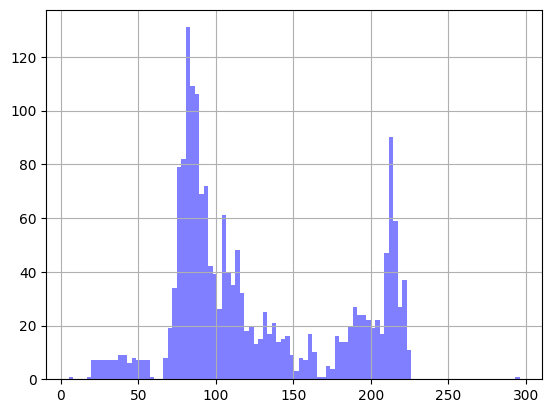

In [27]:
df['iZ'][df['dose'] > 0].hist(bins=100, alpha=0.5, color='blue', label='dose > 0')

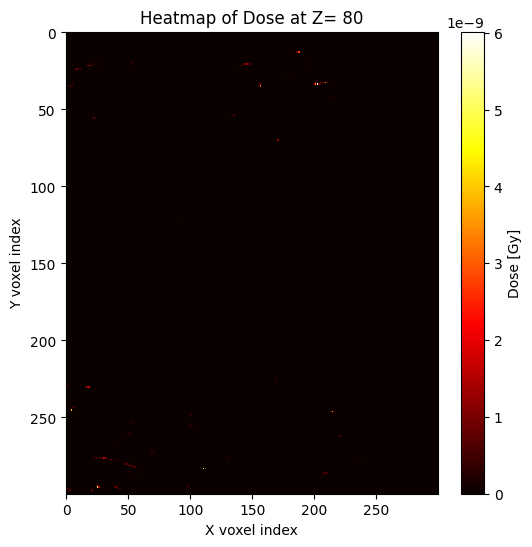

In [28]:

# Load the data
df = pd.read_csv("dDeposit.csv")

# Choose a Y slice to visualize, e.g., y = 0
z_slice = 80
df_slice = df[df['iZ'] == z_slice]

# Create pivot table for heatmap (e.g., X vs Z dose values)
heatmap_data = df_slice.pivot(index='iX', columns='iY', values='dose')

# Sort the index if necessary (Z-axis is usually vertical in heatmaps)
heatmap_data = heatmap_data.sort_index(ascending=False)

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar(label='Dose [Gy]')
plt.title(f'Heatmap of Dose at Z= {z_slice}')
plt.xlabel('X voxel index')
plt.ylabel('Y voxel index')
plt.show()


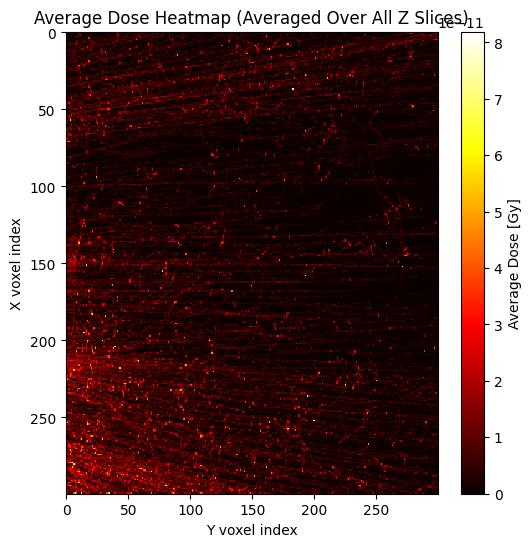

In [29]:
# Load the data
df = pd.read_csv("dDeposit.csv")

# Group by iX and iY and compute the average dose over all iZ
df_avg = df.groupby(['iX', 'iY'])['dose'].mean().reset_index()

# Create a pivot table for the averaged heatmap
heatmap_data = df_avg.pivot(index='iX', columns='iY', values='dose')

# Sort index to match heatmap orientation if needed
heatmap_data = heatmap_data.sort_index(ascending=False)

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar(label='Average Dose [Gy]')
plt.title('Average Dose Heatmap (Averaged Over All Z Slices)')
plt.xlabel('Y voxel index')
plt.ylabel('X voxel index')
plt.show()

In [2]:
def generate_heatmap_from_txt(input_file, z_slice):
    # First pass: find max iX and iY to allocate array
    max_ix = 0
    max_iy = 0

    with open(input_file, 'r') as infile:
        for line in infile:
            if line.startswith('#') or line.strip() == '':
                continue
            parts = line.strip().split(',')
            ix, iy, iz = int(parts[0]), int(parts[1]), int(parts[2])
            if iz == z_slice:
                max_ix = max(max_ix, ix)
                max_iy = max(max_iy, iy)

    # Preallocate array for heatmap
    heatmap = np.zeros((max_ix + 1, max_iy + 1))

    # Second pass: fill heatmap values for target Z slice
    with open(input_file, 'r') as infile:
        for line in infile:
            if line.startswith('#') or line.strip() == '':
                continue
            parts = line.strip().split(',')
            ix, iy, iz = int(parts[0]), int(parts[1]), int(parts[2])
            if iz == z_slice:
                dose = float(parts[3])
                heatmap[ix, iy] = dose  # Assuming 1 dose per voxel

    # Transpose for correct orientation (optional depending on view)
    return heatmap.T  # Y axis becomes vertical, X axis horizontal




In [8]:
# === Usage ===
input_file = 'build/dDeposit.txt'
z_slice = 0  # You can change this to any Z slice of interest

heatmap = generate_heatmap_from_txt(input_file, z_slice)



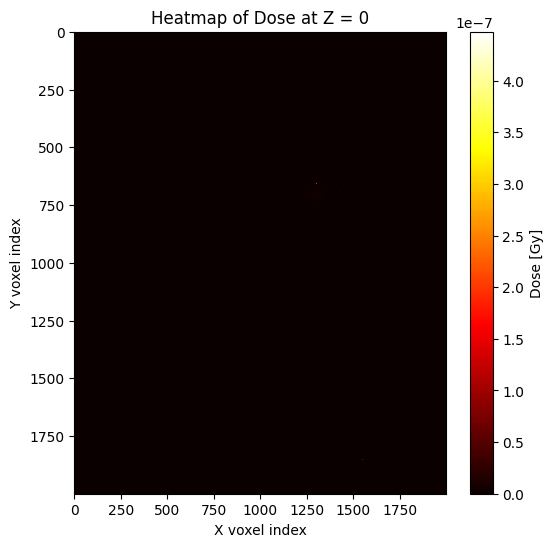

In [9]:
# === Plotting ===
plt.figure(figsize=(6, 6))
plt.imshow(heatmap, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar(label='Dose [Gy]')
plt.title(f'Heatmap of Dose at Z = {z_slice}')
plt.xlabel('X voxel index')
plt.ylabel('Y voxel index')
plt.show()